**Задача:** найти аномальные объекты в ряде данных по конкретному веществу

In [220]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns 

import itertools

import os
from pathlib import Path

#get my written functions
from userfuncs import prepare_dataframe, find_borders_nan_intervals, count_frequency, count_missing

from collections import Counter

#to detect anomalies
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
#import pyod

In [221]:
pd.set_option('display.max_rows', 2000)

In [222]:
#sns.set(style='darkgrid')
from matplotlib import style
style.use('fivethirtyeight')

In [223]:
path_to_data = Path('../../data')
df = pd.read_csv(path_to_data / 'prepared_data_prioksk.csv')
df.head(2)

,TSP,SO2,PB,CD
0,9.0,0.02,21.0,0.54
1,5.0,0.03,20.0,0.53


In [224]:
def count_anomalies(preds):
    '''Count anomalies in yhat from search_anomalies function'''
    
    counts = np.unique(np.where(np.isnan(preds), 0, 1), return_counts=True)
    counts = {np.nan: counts[1][0], counts[0][1]: counts[1][1]}
    #frac = round(counts[1] / sum(counts.values()), 6)
    return counts

def form_df_with_outliers(ts, preds, outlier_name, k=1):
    '''Concat df and create column with outliers to plot them furthere'''
    ts = pd.concat([ts, pd.DataFrame(preds, columns=[outlier_name])], axis=1)
    #detect only very high values, thinking about smal ones as normal values
    ts[f"outlier_val_{outlier_name.split('_')[2]}"] = np.where(ts[outlier_name].notnull().to_numpy() 
                             & (ts[col] > ts[col].median()).to_numpy()
                             , ts[col] * k, np.nan)
    ts[f"outlier_val_{outlier_name.split('_')[2]}_true"] = np.where(ts[outlier_name].notnull().to_numpy() 
                             & (ts[col] > ts[col].median()).to_numpy()
                             , ts[col], np.nan)
    return ts

def fill_dict_frac_values(count_values, cnt_val, elem, method_name, min_thr):
    '''Fill statistics with normal and abnormal values'''
    
    count_values.loc[(elem, 'count normal'), method_name] = cnt_val[np.nan]
    count_values.loc[(elem, 'count anomalies'), method_name] = cnt_val[1]
    count_values.loc[(elem, 'fraction of total %'), method_name] = round(100 * cnt_val[1] / sum(cnt_val.values()), 2)
    count_values.loc[(elem, 'min threshold'), method_name] = min_thr

    return count_values

def search_anomalies(ts, col):
    '''Search anomalies using different algorithms'''
        
    #to store anomalies for element  
    count_values = pd.DataFrame()
    elements = [col]
    index = ['count anomalies', 'count normal', 'fraction of total %', 'min threshold']
    multindex = pd.MultiIndex.from_tuples([(elem, ix) for elem in elements for ix in index])
    count_values = pd.DataFrame(index=multindex)
       
    ##Isolation Forest##
    iforest = IsolationForest(n_estimators=300, contamination=0.03, random_state=42, n_jobs=-1)
    #1 - outliers, 0 - no outlier
    preds = [1 if x == -1 else np.nan for x in iforest.fit_predict(ts[[col]])]

    ts = form_df_with_outliers(ts=ts, preds=preds, outlier_name='is_outlier_iforest', k=1)
    count_values = fill_dict_frac_values(count_values=count_values, cnt_val=count_anomalies(preds), method_name='IForest'
                         , elem=col, min_thr=ts[['outlier_val_iforest_true']].min().values[0])
    
    ##LOF##
    k_neigh = int(0.05 * ts.shape[0]) #can be changed
    lof = LocalOutlierFactor(n_neighbors=k_neigh, n_jobs=-1)
    #1 - outliers, 0 - no outlier
    preds = [1 if x == -1 else np.nan for x in lof.fit_predict(ts[[col]])]
    
    ts = form_df_with_outliers(ts=ts, preds=preds, outlier_name='is_outlier_lof', k=0.96)
    count_values = fill_dict_frac_values(count_values=count_values, cnt_val=count_anomalies(preds), method_name='LOF'
                         , elem=col, min_thr=ts[['outlier_val_lof_true']].min().values[0])
    
    ##IQR##
    q25, q75 = np.quantile(ts[[col]], q=[0.25, 0.75])
    iqr = q75 - q25
    min_q, max_q = q25 - 2 * iqr, q75 + 2 * iqr
    preds = np.where(ts[[col]] > max_q, 1, np.nan).squeeze()
    
    ts = form_df_with_outliers(ts=ts, preds=preds, outlier_name='is_outlier_iqr', k=0.93)
    count_values = fill_dict_frac_values(count_values=count_values, cnt_val=count_anomalies(preds), method_name='IQR'
                         , elem=col, min_thr=ts[['outlier_val_iqr_true']].dropna().min().values)



    ##Z-score##
    threshold = 3 #often 2,2.5,3,3.5 #can be changed
    z_scores = ((ts[[col]] - ts[[col]].mean()) / ts[[col]].std()).to_numpy()
    preds = [1 if abs(x) > threshold else np.nan for x in z_scores]
    
    ts = form_df_with_outliers(ts=ts, preds=preds, outlier_name='is_outlier_z-score', k=0.9)
    count_values = fill_dict_frac_values(count_values=count_values, cnt_val=count_anomalies(preds), method_name='Z-score'
                         , elem=col, min_thr=ts[['outlier_val_z-score_true']].min().values[0])

    return count_values, ts

In [225]:
count_values = {}.fromkeys(df.columns)
d_elem_anomal = {}.fromkeys(df.columns)

In [226]:
for col in df.columns:
    count_values[col], d_elem_anomal[col] = search_anomalies(df[[col]], col)

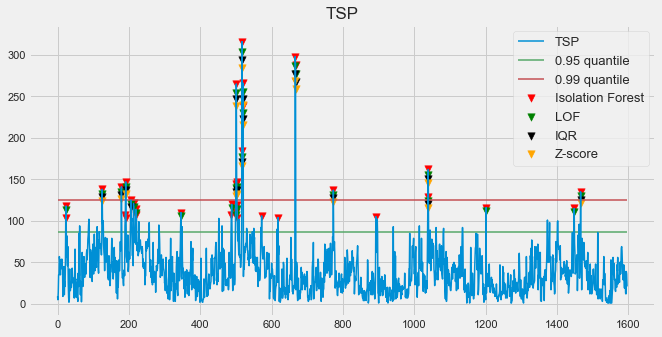

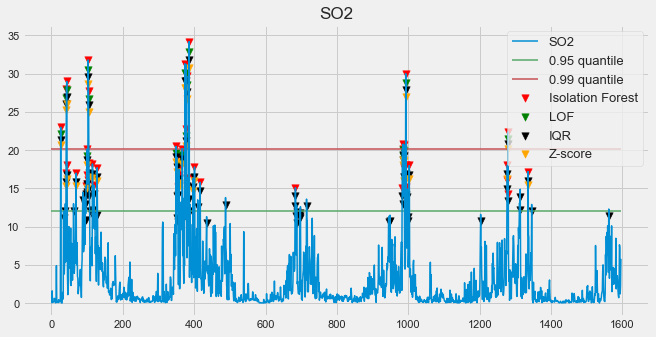

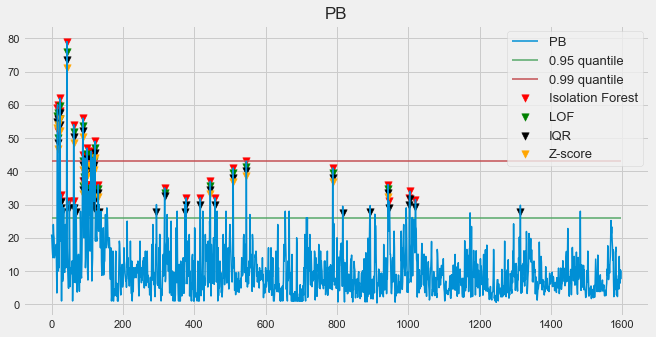

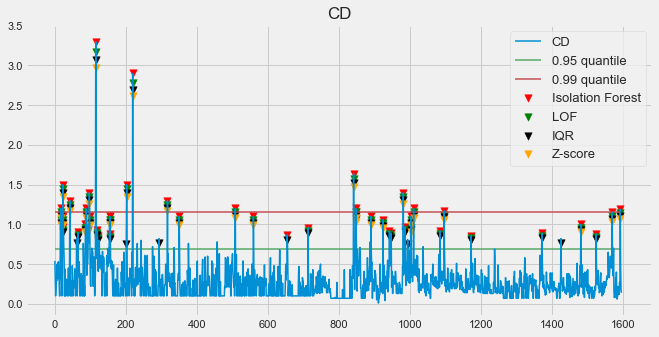

In [248]:
q1, q2 = 0.95, 0.99
fontsize = 13
lw = 1.5
for col in df.columns:
    ts = d_elem_anomal[col]
    plt.figure(figsize=(10, 5))
    plt.title(label=col, size=17)
    #quantiles
    k = np.quantile(ts[col].to_numpy(), [q1, q2])
    plt.hlines(k[0], xmin=min(ts.index), xmax=max(ts.index), color='g', label=f'{q1} quantile', lw=lw)
    plt.hlines(k[1], xmin=min(ts.index), xmax=max(ts.index), color='r', label=f'{q2} quantile', lw=lw)

    #plt.fill_between(ts.index, ts[col])
    plt.plot(ts.index, ts[[col]], label=f"{col}", lw=lw)
    
    s = 55
    plt.scatter(ts.index, ts['outlier_val_iforest'], marker='v', color='red', s=s, label='Isolation Forest')
    plt.scatter(ts.index, ts['outlier_val_lof'], marker='v', color='green', s=s, label='LOF')
    plt.scatter(ts.index, ts['outlier_val_iqr'], marker='v', color='black', s=s, label='IQR')
    plt.scatter(ts.index, ts['outlier_val_z-score'], marker='v', color='orange', s=s, label='Z-score')
#    plt.xlabel('Observation')
#    plt.ylabel('Quantity')
    plt.legend(fontsize=fontsize)


In [236]:
statistics = None
for col in count_values.keys():
    if statistics is None:
        statistics = count_values[col]
    else:
        statistics = pd.concat([statistics, count_values[col]])
statistics

IForest      LOF      IQR  Z-score
TSP count anomalies        48.00    26.00    17.00    16.00
    count normal         1549.00  1571.00  1580.00  1581.00
    fraction of total %     3.01     1.63     1.06     1.00
    min threshold         104.00   110.00   125.00   129.00
SO2 count anomalies        48.00    19.00    95.00    37.00
    count normal         1549.00  1578.00  1502.00  1560.00
    fraction of total %     3.01     1.19     5.95     2.32
    min threshold          14.30    19.10    11.30    16.30
PB  count anomalies        46.00    29.00    53.00    27.00
    count normal         1551.00  1568.00  1544.00  1570.00
    fraction of total %     2.88     1.82     3.32     1.69
    min threshold          31.00    35.00    29.50    36.00
CD  count anomalies        47.00    75.00    52.00    33.00
    count normal         1550.00  1522.00  1545.00  1564.00
    fraction of total %     2.94     4.70     3.26     2.07
    min threshold           0.86     0.86     0.81     1.00

In [250]:
statistics.T

TSP                                                 \
        count anomalies count normal fraction of total % min threshold   
IForest            48.0       1549.0                3.01         104.0   
LOF                26.0       1571.0                1.63         110.0   
IQR                17.0       1580.0                1.06         125.0   
Z-score            16.0       1581.0                1.00         129.0   

                    SO2                                                 \
        count anomalies count normal fraction of total % min threshold   
IForest            48.0       1549.0                3.01          14.3   
LOF                19.0       1578.0                1.19          19.1   
IQR                95.0       1502.0                5.95          11.3   
Z-score            37.0       1560.0                2.32          16.3   

                     PB                                                 \
        count anomalies count normal fraction of total % min threshold   
IForest            46.0       1551.0                2.88          31.0   
LOF                29.0       1568.0                1.82          35.0   
IQR                53.0       1544.0                3.32          29.5   
Z-score            27.0       1570.0                1.69          36.0   

                     CD                                                 
        count anomalies count normal fraction of total % min threshold  
IForest            47.0       1550.0                2.94          0.86  
LOF                75.0       1522.0                4.70          0.86  
IQR                52.0       1545.0                3.26          0.81  
Z-score            33.0       1564.0                2.07          1.00

# 